# 08 - Link Prediction Pipeline with Node Embeddings

Este notebook constrói um pipeline completo de *link prediction* usando:

- o grafo de colaboração (`collaboration.edgelist.txt`);
- os embeddings de nós gerados pela GNN;
- um classificador simples (Logistic Regression) para prever a existência de arestas.

Fluxo:

1. Carregar grafo e embeddings.
2. Gerar splits de arestas (train/val/test) com amostragem de não-arestas.
3. Construir features a partir dos embeddings.
4. Treinar e avaliar um modelo de predição de links.
5. Salvar métricas e splits em CSV.


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

plt.style.use("default")

# Caminhos absolutos para este ambiente
DATA_PATH = Path("/workspace/data/collaboration.edgelist.txt")
EMBEDDINGS_CSV = Path("/workspace/results/06_node_embeddings_raw.csv")

DATA_DIR = DATA_PATH.parent
PROJECT_DIR = DATA_DIR.parent
RESULTS_DIR = PROJECT_DIR / "results"
FIG_DIR = RESULTS_DIR / "figures"

RESULTS_DIR.mkdir(exist_ok=True, parents=True)
FIG_DIR.mkdir(exist_ok=True, parents=True)

print("PROJECT_DIR:", PROJECT_DIR)
print("DATA_DIR:", DATA_DIR)
print("RESULTS_DIR:", RESULTS_DIR)
print("FIG_DIR:", FIG_DIR)

print("EDGELIST_PATH:", DATA_PATH, "| exists =", DATA_PATH.exists())
print("EMBEDDINGS_CSV:", EMBEDDINGS_CSV, "| exists =", EMBEDDINGS_CSV.exists())


PROJECT_DIR: /workspace
DATA_DIR: /workspace/data
RESULTS_DIR: /workspace/results
FIG_DIR: /workspace/results/figures
EDGELIST_PATH: /workspace/data/collaboration.edgelist.txt | exists = True
EMBEDDINGS_CSV: /workspace/results/06_node_embeddings_raw.csv | exists = True


## 1. Carregar grafo e embeddings


In [2]:
def load_graph(path: Path) -> nx.Graph:
    if not path.exists():
        raise FileNotFoundError(f"Edge list not found at: {path}")
    df_edges = pd.read_csv(
        path,
        sep=r"\s+",
        header=None,
        usecols=[0, 1],
        names=["source", "target"],
        dtype={"source": int, "target": int},
    )
    G = nx.Graph()
    G.add_edges_from(zip(df_edges["source"], df_edges["target"]))
    return G


def load_embeddings(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Embeddings CSV not found at: {path}")
    df = pd.read_csv(path)
    if "node" not in df.columns:
        raise ValueError("Expected a 'node' column in embeddings CSV.")
    return df


G = load_graph(DATA_PATH)

print("\n=== GRAPH OVERVIEW ===")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Is directed:", G.is_directed())
print("Is connected:", nx.is_connected(G))

df_emb = load_embeddings(EMBEDDINGS_CSV)
print("Embeddings shape:", df_emb.shape)

# Garantir que a coluna 'node' é int
df_emb["node"] = df_emb["node"].astype(int)

# Criar um dicionário: node_id -> vetor de embedding (np.ndarray)
embed_cols = [c for c in df_emb.columns if c.startswith("dim_")]
emb_dim = len(embed_cols)
print("Embedding dimension:", emb_dim)

emb_dict = {
    int(row["node"]): row[embed_cols].to_numpy(dtype=float)
    for _, row in df_emb.iterrows()
}



=== GRAPH OVERVIEW ===
Number of nodes: 23133
Number of edges: 93439
Is directed: False
Is connected: False
Embeddings shape: (23133, 66)
Embedding dimension: 64


## 2. Criar splits de arestas (train/val/test) e amostrar não-arestas

- Usamos 70% das arestas para treino, 15% para validação e 15% para teste.
- Para cada split, amostramos o mesmo número de pares negativos (não-arestas).


In [3]:
rng = np.random.default_rng(seed=42)

edges = np.array(G.edges(), dtype=int)
num_edges = edges.shape[0]
print("Total edges:", num_edges)

# Embaralhar índices
idx = rng.permutation(num_edges)

train_frac, val_frac = 0.7, 0.15
train_end = int(train_frac * num_edges)
val_end = train_end + int(val_frac * num_edges)

idx_train = idx[:train_end]
idx_val = idx[train_end:val_end]
idx_test = idx[val_end:]

edges_train = edges[idx_train]
edges_val = edges[idx_val]
edges_test = edges[idx_test]

len_train, len_val, len_test = len(edges_train), len(edges_val), len(edges_test)
print(f"Train edges: {len_train}, Val edges: {len_val}, Test edges: {len_test}")


Total edges: 93439
Train edges: 65407, Val edges: 14015, Test edges: 14017


In [4]:
nodes = np.array(G.nodes(), dtype=int)
num_nodes = len(nodes)

def sample_negative_edges(G: nx.Graph, num_samples: int, rng: np.random.Generator, max_trials: int = 10_000_000):
    # Amostra pares (u, v) que NÃO são arestas no grafo.
    neg_edges = set()
    trials = 0
    while len(neg_edges) < num_samples and trials < max_trials:
        u = int(rng.choice(nodes))
        v = int(rng.choice(nodes))
        if u == v:
            trials += 1
            continue
        if G.has_edge(u, v):
            trials += 1
            continue
        if (u, v) in neg_edges or (v, u) in neg_edges:
            trials += 1
            continue
        neg_edges.add((u, v))
        trials += 1
    if len(neg_edges) < num_samples:
        print(f"Warning: only sampled {len(neg_edges)} negative edges (requested {num_samples}).")
    return np.array(list(neg_edges), dtype=int)


neg_train = sample_negative_edges(G, len_train, rng)
neg_val = sample_negative_edges(G, len_val, rng)
neg_test = sample_negative_edges(G, len_test, rng)

print("Negative edges sampled:",
      "train:", len(neg_train),
      "val:", len(neg_val),
      "test:", len(neg_test))


Negative edges sampled: train: 65407 val: 14015 test: 14017


In [5]:
def build_edge_dataframe(pos_edges: np.ndarray, neg_edges: np.ndarray, split_name: str) -> pd.DataFrame:
    df_pos = pd.DataFrame(pos_edges, columns=["u", "v"])
    df_pos["label"] = 1
    df_neg = pd.DataFrame(neg_edges, columns=["u", "v"])
    df_neg["label"] = 0
    df = pd.concat([df_pos, df_neg], ignore_index=True)
    df["split"] = split_name
    return df


df_train = build_edge_dataframe(edges_train, neg_train, "train")
df_val = build_edge_dataframe(edges_val, neg_val, "val")
df_test = build_edge_dataframe(edges_test, neg_test, "test")

df_edges_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
print(df_edges_all["split"].value_counts())
print(df_edges_all["label"].value_counts())

splits_path = RESULTS_DIR / "08_edge_splits.csv"
df_edges_all.to_csv(splits_path, index=False)
print("Saved edge splits to:", splits_path)

display(df_edges_all.head())


split
train    130814
test      28034
val       28030
Name: count, dtype: int64
label
1    93439
0    93439
Name: count, dtype: int64
Saved edge splits to: /workspace/results/08_edge_splits.csv


,u,v,label,split
0,14097,19856,1,train
1,16449,10738,1,train
2,10217,12337,1,train
3,8516,12628,1,train
4,10310,18193,1,train


## 3. Construir features de arestas a partir dos embeddings


In [6]:
def edge_to_features(u: int, v: int) -> np.ndarray:
    # Cria vetor de features para a aresta (u, v) usando embeddings.
    if u not in emb_dict or v not in emb_dict:
        raise KeyError(f"Node {u} or {v} not found in embeddings.")
    z_u = emb_dict[u]
    z_v = emb_dict[v]
    # Hadamard product
    had = z_u * z_v
    # Diferença absoluta
    diff = np.abs(z_u - z_v)
    # Concatenação (2 * emb_dim)
    return np.concatenate([had, diff], axis=0)


feat_dim = emb_dim * 2
print("Feature dimension for each edge:", feat_dim)


def build_Xy(df_edges: pd.DataFrame):
    X = np.zeros((len(df_edges), feat_dim), dtype=float)
    y = df_edges["label"].to_numpy(dtype=int)
    for i, row in df_edges.iterrows():
        X[i] = edge_to_features(int(row["u"]), int(row["v"]))
    return X, y


X_train, y_train = build_Xy(df_train)
X_val, y_val = build_Xy(df_val)
X_test, y_test = build_Xy(df_test)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)


Feature dimension for each edge: 128
X_train shape: (130814, 128) y_train shape: (130814,)
X_val shape: (28030, 128) y_val shape: (28030,)
X_test shape: (28034, 128) y_test shape: (28034,)


## 4. Treinar modelo de link prediction e avaliar (AUC, AP)


In [7]:
clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1,
)

clf.fit(X_train, y_train)

def evaluate_split(name: str, X: np.ndarray, y: np.ndarray) -> dict:
    y_scores = clf.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, y_scores)
    ap = average_precision_score(y, y_scores)
    print(f"{name} - AUC: {auc:.4f}, AP: {ap:.4f}")
    return {
        "split": name,
        "auc": auc,
        "ap": ap,
        "num_samples": len(y),
        "pos_samples": int(y.sum()),
        "neg_samples": int((y == 0).sum()),
    }

results = []
results.append(evaluate_split("train", X_train, y_train))
results.append(evaluate_split("val", X_val, y_val))
results.append(evaluate_split("test", X_test, y_test))

df_results = pd.DataFrame(results)
results_path = RESULTS_DIR / "08_link_prediction_results.csv"
df_results.to_csv(results_path, index=False)
print("Saved link prediction results to:", results_path)

display(df_results)


train - AUC: 0.9156, AP: 0.9055
val - AUC: 0.9183, AP: 0.9093
test - AUC: 0.9191, AP: 0.9100
Saved link prediction results to: /workspace/results/08_link_prediction_results.csv


,split,auc,ap,num_samples,pos_samples,neg_samples
0,train,0.915600,0.905534,130814,65407,65407
1,val,0.918286,0.909311,28030,14015,14015
2,test,0.919109,0.909960,28034,14017,14017


## 5. Curvas ROC e Precision-Recall no conjunto de teste


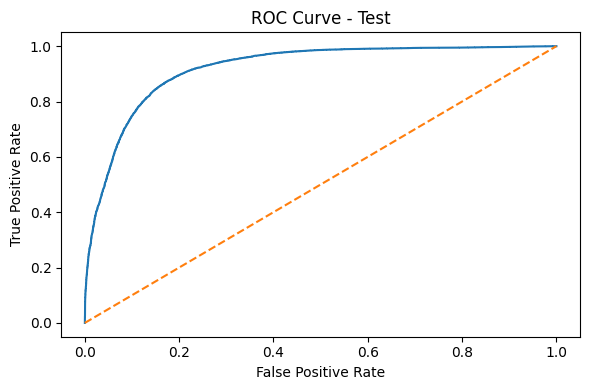

Saved ROC curve to: /workspace/results/figures/08_roc_curve_test.png


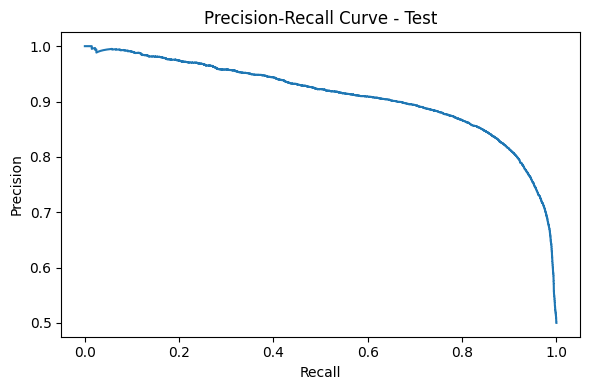

Saved PR curve to: /workspace/results/figures/08_pr_curve_test.png


In [8]:
y_scores_test = clf.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_scores_test)
prec, rec, _ = precision_recall_curve(y_test, y_scores_test)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test")
plt.tight_layout()
roc_path = FIG_DIR / "08_roc_curve_test.png"
plt.savefig(roc_path, dpi=150)
plt.show()
print("Saved ROC curve to:", roc_path)

plt.figure(figsize=(6, 4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Test")
plt.tight_layout()
pr_path = FIG_DIR / "08_pr_curve_test.png"
plt.savefig(pr_path, dpi=150)
plt.show()
print("Saved PR curve to:", pr_path)


In [9]:
print('Notebook 08 finished successfully. 🚀')

Notebook 08 finished successfully. 🚀
